In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Package for time
from datetime import datetime

# Package for KDE's
from sklearn.neighbors import KernelDensity

In [2]:
SavePlots = True

In [3]:
# Import data
data = pd.read_csv('Data/cpd-crash-incidents.csv', sep=';')
data

,tamainid,location_description,rdfeature,rdcharacter,rdclass,rdconfigur,rdsurface,rdcondition,lightcond,weather,...,fatalities,injuries,month,contrfact1,contrfact2,contributing_factor,vehicleconcat1,vehicleconcat2,vehicleconcat3,vehicle_type
0,20603,140 FEET FROM PVA (2234 WALNUT ST),NO SPECIAL FEATURE,"STRAIGHT,LEVEL",PUBLIC VEHICULAR AREA,"TWO-WAY,NOT DIVIDED",SMOOTH ASPHALT,DRY,DAYLIGHT,CLOUDY,...,No,No,1,NaN,NONE,NONE,"PASSENGER CAR,SPORT UTILITY","PASSENGER CAR,SPORT UTILITY","PASSENGER CAR,SPORT UTILITY","PASSENGER CAR,SPORT UTILITY"
1,20606,.10 MILES FROM PVA OF 150 WRENN DR,NO SPECIAL FEATURE,"STRAIGHT,LEVEL",PUBLIC VEHICULAR AREA,"ONE-WAY,NOT DIVIDED",SMOOTH ASPHALT,DRY,DAYLIGHT,CLEAR,...,No,No,1,NaN,NONE,NONE,"SPORT UTILITY,VAN","SPORT UTILITY,VAN","SPORT UTILITY,VAN","SPORT UTILITY,VAN"
2,20607,30 FEET FROM SR1300(KILDAIRE FARM RD),RELATED TO INTERSECTION,"STRAIGHT,LEVEL",STATE SECONDARY ROUTE,"TWO-WAY,DIVIDED,UNPROTECTED MEDIAN",SMOOTH ASPHALT,DRY,DAYLIGHT,CLEAR,...,No,No,1,NaN,NONE,NONE,"PASSENGER CAR,PASSENGER CAR","PASSENGER CAR,PASSENGER CAR","PASSENGER CAR,PASSENGER CAR","PASSENGER CAR,PASSENGER CAR"
3,20609,35 FEET FROM NC 54 HWY (NW MAYNARD RD),RELATED TO INTERSECTION,"STRAIGHT,LEVEL",NC ROUTE,"TWO-WAY,DIVIDED,UNPROTECTED MEDIAN",COARSE ASPHALT,DRY,DAYLIGHT,CLEAR,...,No,No,1,NaN,NONE,NONE,"PASSENGER CAR,SPORT UTILITY","PASSENGER CAR,SPORT UTILITY","PASSENGER CAR,SPORT UTILITY","PASSENGER CAR,SPORT UTILITY"
4,20628,300 FEET FROM US 64 HWY,RELATED TO INTERSECTION,"STRAIGHT,GRADE",US ROUTE,"TWO-WAY,DIVIDED,UNPROTECTED MEDIAN",SMOOTH ASPHALT,DRY,DAYLIGHT,CLOUDY,...,No,No,1,NaN,NONE,NONE,"VAN,PASSENGER CAR","VAN,PASSENGER CAR","VAN,PASSENGER CAR","VAN,PASSENGER CAR"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23453,47069,CARY,FOUR-WAY INTERSECTION,"STRAIGHT,LEVEL",STATE SECONDARY ROUTE,"TWO-WAY,NOT DIVIDED",SMOOTH ASPHALT,DRY,DAYLIGHT,CLEAR,...,No,Yes,3,NONE,"NONE,NONE","NONE,NONE","PASSENGER CAR,PASSENGER CAR","PASSENGER CAR,PASSENGER CAR","PASSENGER CAR,PASSENGER CAR","PASSENGER CAR,PASSENGER CAR"
23454,47070,CARY,FOUR-WAY INTERSECTION,"STRAIGHT,LEVEL",STATE SECONDARY ROUTE,"TWO-WAY,DIVIDED,UNPROTECTED MEDIAN",SMOOTH ASPHALT,DRY,DARK - LIGHTED ROADWAY,CLEAR,...,No,Yes,3,NaN,NONE,NONE,"VAN,PASSENGER CAR","VAN,PASSENGER CAR,PASSENGER CAR","VAN,PASSENGER CAR,PASSENGER CAR","VAN,PASSENGER CAR,PASSENGER CAR"
23455,47077,.314 MILES FROM P.V.A. 275 CONVENTION DR,NaN,NaN,PUBLIC VEHICULAR AREA,"ONE-WAY,NOT DIVIDED",SMOOTH ASPHALT,DRY,DAYLIGHT,CLEAR,...,No,No,3,NaN,NONE,NONE,"UNKNOWN,PASSENGER CAR","UNKNOWN,PASSENGER CAR","UNKNOWN,PASSENGER CAR","UNKNOWN,PASSENGER CAR"
23456,47079,CARY,FOUR-WAY INTERSECTION,"STRAIGHT,GRADE",STATE SECONDARY ROUTE,"TWO-WAY,NOT DIVIDED",SMOOTH ASPHALT,DRY,DAYLIGHT,CLEAR,...,No,No,3,NONE,"NONE,NONE","NONE,NONE","PASSENGER CAR,SPORT UTILITY","PASSENGER CAR,SPORT UTILITY","PASSENGER CAR,SPORT UTILITY","PASSENGER CAR,SPORT UTILITY"


# Problem 2A

## Scatter plot of positions
Picture from: https://earth.google.com/web/search/Cary,+North+Carolina,+USA/@35.78987892,-78.61106232,86.67345621a,144709.62715074d,35y,0h,0t,0r/data=CigiJgokCffcV6gl5zVAEfjcV6gl5zXAGTosvyL2DEFAIXolIgekglHA

In [4]:
# Extract positions
x = data['lon']
y = data['lat']

# Load image taken from google earth
img = plt.imread("Data/cary_map.png")

# Define the limiters of the image in decimal degrees
xlim = (-78.25, -79.25)
ylim = (35.5, 36.08333)

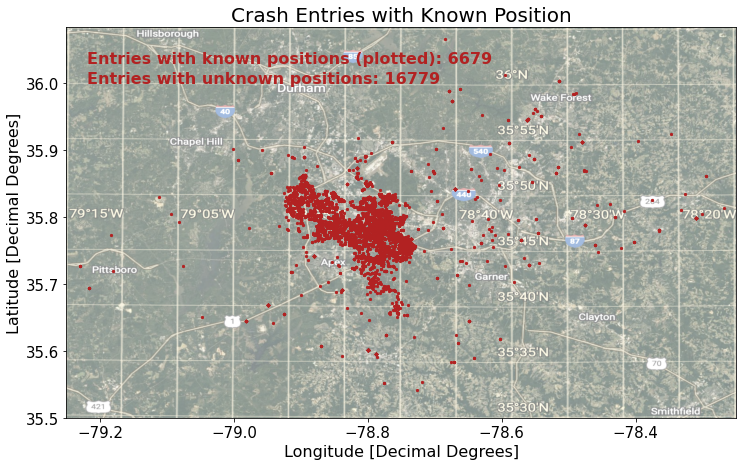

In [5]:
# Plot
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(img, extent=[xlim[1],xlim[0],ylim[0],ylim[1]],alpha=0.5) #[left, right, bottom, top]
ax.scatter(x,y, color='firebrick', s=5)

# Note number of plotted positions and non-plotted
ax.text(-79.22, 36.03, f'Entries with known positions (plotted): {len(x)-np.sum(x.isna())}',fontsize=16,c='firebrick',weight='bold')
ax.text(-79.22, 36, f'Entries with unknown positions: {np.sum(x.isna())}',fontsize=16,c='firebrick',weight='bold')

# Plot preferences
ax.set_xlabel('Longitude [Decimal Degrees]', fontsize=16)
ax.set_ylabel('Latitude [Decimal Degrees]', fontsize=16)
ax.set_title('Crash Entries with Known Position', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

if SavePlots: plt.savefig('Plots/2a_pos.png')
plt.show()

## Histogram of the time of day

There are two columns which have time stamps: 'crash_date' and 'ta_time'. According to the official site: https://data.townofcary.org/explore/dataset/cpd-crash-incidents/information/?disjunctive.rdfeature&disjunctive.rdcharacter&disjunctive.rdclass&disjunctive.rdconfigur&disjunctive.rdsurface&disjunctive.rdcondition&disjunctive.lightcond&disjunctive.weather&disjunctive.trafcontrl&disjunctive.month&disjunctive.contributing_factor&disjunctive.vehicle_type&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJsaW5lIiwiZnVuYyI6IkNPVU5UIiwieUF4aXMiOiJ0YW1haW5pZCIsImNvbG9yIjoiIzY2YzJhNSIsInNjaWVudGlmaWNEaXNwbGF5Ijp0cnVlfV0sInhBeGlzIjoiY3Jhc2hfZGF0ZSIsIm1heHBvaW50cyI6IiIsInRpbWVzY2FsZSI6Im1vbnRoIiwic29ydCI6IiIsImNvbmZpZyI6eyJkYXRhc2V0IjoiY3BkLWNyYXNoLWluY2lkZW50cyIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUucmRmZWF0dXJlIjp0cnVlLCJkaXNqdW5jdGl2ZS5yZGNoYXJhY3RlciI6dHJ1ZSwiZGlzanVuY3RpdmUucmRjbGFzcyI6dHJ1ZSwiZGlzanVuY3RpdmUucmRjb25maWd1ciI6dHJ1ZSwiZGlzanVuY3RpdmUucmRzdXJmYWNlIjp0cnVlLCJkaXNqdW5jdGl2ZS5yZGNvbmRpdGlvbiI6dHJ1ZSwiZGlzanVuY3RpdmUubGlnaHRjb25kIjp0cnVlLCJkaXNqdW5jdGl2ZS53ZWF0aGVyIjp0cnVlLCJkaXNqdW5jdGl2ZS50cmFmY29udHJsIjp0cnVlLCJkaXNqdW5jdGl2ZS5tb250aCI6dHJ1ZSwiZGlzanVuY3RpdmUuY29udHJpYnV0aW5nX2ZhY3RvciI6dHJ1ZSwiZGlzanVuY3RpdmUudmVoaWNsZV90eXBlIjp0cnVlfX19XSwidGltZXNjYWxlIjoieWVhciIsImRpc3BsYXlMZWdlbmQiOnRydWUsImFsaWduTW9udGgiOnRydWV9&location=10,36.04133,-78.45474&basemap=jawg.streets
the description of ta_time is time of crash. 'crash_date' has no description. While crash date has a more consistent data format we cannot be sure this is right - especially since the times differ from ta_time.

UPDATE: I saw the assignment asks for the time given in crash date so we will use this column instead.

In [6]:
# There are different formats - depends on how long the string is if seconds is included
data['crash_date'][0:10]

0    2016-01-01T18:20:09+00:00
1    2016-01-02T15:38:00+00:00
2    2016-01-02T19:21:32+00:00
3    2016-01-02T21:43:21+00:00
4    2016-01-04T14:00:20+00:00
5    2016-01-04T14:22:45+00:00
6    2016-01-05T00:27:34+00:00
7    2016-01-05T22:28:04+00:00
8    2016-01-05T21:54:18+00:00
9    2016-01-05T23:22:46+00:00
Name: crash_date, dtype: object

In [7]:
# Make an array to store times in hours
times_hours = []

# Loop over list
for i in range(len(data['crash_date'])):
    
    # Get hours and minutes (we exclude seconds since we dont have them for all)
    # %Y-%m-%d = date, %H = hours, %M = minutes, %S = seconds
    hours = datetime.strptime(data['crash_date'][i], '%Y-%m-%dT%H:%M:%S+00:%f').hour
    mins = datetime.strptime(data['crash_date'][i], '%Y-%m-%dT%H:%M:%S+00:%f').minute
    
    # Store the time
    times_hours.append( hours + mins/60 )
    
# Save it to the pandas dataframme
data['times_hours'] = times_hours

In [8]:
data['times_hours']

0        18.333333
1        15.633333
2        19.350000
3        21.716667
4        14.000000
           ...    
23453     2.000000
23454     1.300000
23455    22.983333
23456    22.883333
23457     1.750000
Name: times_hours, Length: 23458, dtype: float64

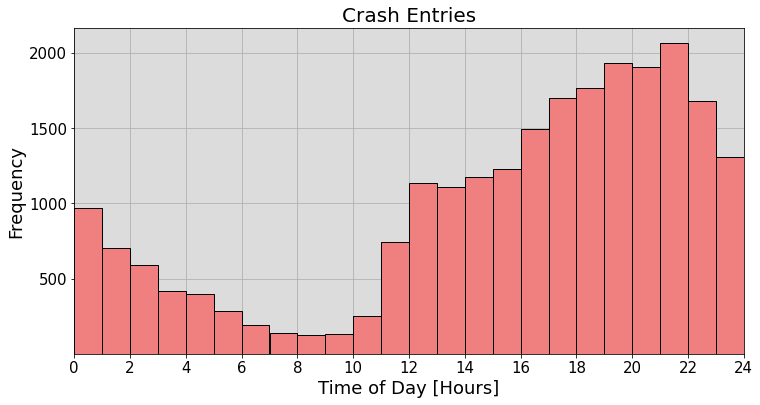

In [9]:
# Plotting
fig, ax = plt.subplots(figsize=(12,6))

bins = np.arange(0,25,1)
ax.hist(data['times_hours'], bins, color='lightcoral',ec='k',zorder=3)

ax.set_facecolor('gainsboro')
ax.grid('white')

ax.set_xlabel('Time of Day [Hours]', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_title('Crash Entries', fontsize=20)

plt.xticks(bins[::2],fontsize=15)
plt.yticks([500,1000,1500,2000], fontsize=15)
plt.xlim(0,24)

if SavePlots: plt.savefig('Plots/2a_times.png')
plt.show()

## Description of Kernel Density
In the write-up

# Problem 2B

In [10]:
# Define bandwidth
h = 0.8

In [11]:
# Define function that returns the pdf
def Epanechnikov_Kernel_PDF(X, X_plot, bandwidth):
    """
    INPUTs:
    X = the data samples
    X_plot = the points we want to evaluate the pdf at
    bandwidth = the bandwidth to use in the kernel
    
    OUTPUTs:
    PDF = the pdf evaluated at X_plot
    """
    
    # Get the number of events in sample (used to normalize later)
    N_events = len(X)
    
    # Define Epanechnikov kernel
    K = lambda u: 3/4 * (1-u**2)
    
    # Create and empty array to store the pdf in
    PDF = np.zeros_like(X_plot)
    
    # Loop over X_plot values to evaluate the pdf
    for i in range(len(X_plot)):
        
        # Find the distance to all events
        dist = X_plot[i] - X
        
        # Ensure the wrapping of the data is considered, i.e. we want 12 hours on each side
        dist[dist > 12] -= 24
        dist[dist < -12] += 24
        dist = dist
        
        # Compute pdf for that point
        K_calc = K( dist/bandwidth )
        
        # Take only the positive values of K since u is only defined between -1 and 1
        positive_mask = ( K_calc > 0 )
        pdf_point = np.sum( K_calc[positive_mask] )

        PDF[i] = pdf_point
    
    # Normalise and return
    return 1/(N_events*bandwidth) * PDF

In [12]:
x_arr = np.linspace(0,24,100)
pdf_arr = Epanechnikov_Kernel_PDF(X=data['times_hours'], X_plot=x_arr, bandwidth=0.8)

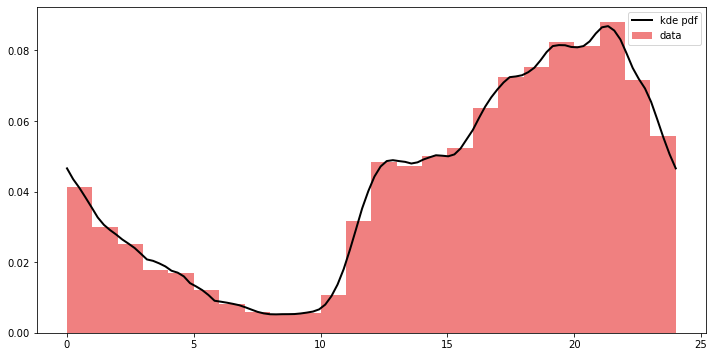

In [13]:
# Plotting
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(x_arr, pdf_arr, color='k', linewidth=2, label='kde pdf')
ax.hist(data['times_hours'], bins=bins, density=True, color='lightcoral', label='data')
ax.legend()

plt.show()

In [14]:
pdf_arr[0], pdf_arr[-1]

(0.04657549460627327, 0.04657549460627327)

## Evaluate pdf at specific times

In [15]:
# Define times to evaluate as strings
t_eval_str = ['00:23', '01:49', '08:12', '15:55', '18:02', '21:12', '23:44']

# Convert to hours
t_eval_hours = np.zeros(len(t_eval_str))

for i in range(len(t_eval_str)):
    
    # Get hours and minutes (we exclude seconds since we dont have them for all)
    # %H = hours up to 24, %M = minutes
    hours = datetime.strptime(t_eval_str[i], '%H:%M').hour
    mins = datetime.strptime(t_eval_str[i], '%H:%M').minute

    # Store the time
    t_eval_hours[i] = hours + mins/60
    
t_eval_hours

array([ 0.38333333,  1.81666667,  8.2       , 15.91666667, 18.03333333,
       21.2       , 23.73333333])

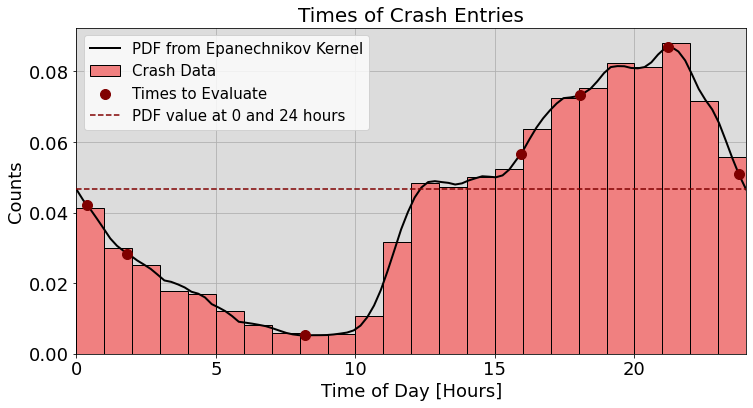

In [16]:
# Evaluate at the right times
pdf_eval = Epanechnikov_Kernel_PDF(X=data['times_hours'], X_plot=t_eval_hours, bandwidth=0.8)

# Plotting
fig, ax = plt.subplots(figsize=(12,6))

ax.set_facecolor('gainsboro')
ax.grid('white')

ax.plot(x_arr, pdf_arr, color='k', linewidth=2, label='PDF from Epanechnikov Kernel')
ax.hist(data['times_hours'], bins=bins, density=True, ec='k',color='lightcoral',label='Crash Data',zorder=2)

ax.scatter(t_eval_hours, pdf_eval, color='maroon', s=100, zorder=4, label='Times to Evaluate')

ax.hlines(pdf_arr[-1],0,24,zorder=4, linestyle='dashed', color='maroon', label='PDF value at 0 and 24 hours')

ax.legend(prop={'size':15})
plt.xlim(0,24)

ax.set_title('Times of Crash Entries', fontsize=20)
ax.set_ylabel('Counts', fontsize=18)
ax.set_xlabel('Time of Day [Hours]', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

if SavePlots: plt.savefig('Plots/2b_kernel_pdf.png')

plt.show()

In [17]:
pdf_eval

array([0.04220486, 0.02839967, 0.00522866, 0.05645703, 0.07334612,
       0.08689226, 0.05104639])

## Police patrols roads
Using only the time KDE PDF, if additional police officers patrolling the roads
reduced the relative crash rates by 10% for a duration of 2 continuous hours, what 2-
hour window would be the best to patrol? How much would the 24-hour percentage
of crashes be reduced for your choice of 2-hour window of additional patrols?

- We make sort of a raster scan starting every minute in the 24 hours period, meaning we evaluate 24*60 integrals. For each minute we compute what the reduction will be in the next two hour time period, and how the overall number of crashes would reduce. We can then plot this as a function of the time the two hour period start.

In [18]:
# We need the kde pdf for each minute in the 24 hours interval
N_times = 24*60
times_patrol = np.arange(0, N_times, 1) / 60 #in hours
pdf_patrol = Epanechnikov_Kernel_PDF(X=data['times_hours'], X_plot=times_patrol, bandwidth=0.8)

In [19]:
# Concatenate the arrays with the first two hour window to account for the cyclic behaviour
times_patrol_cyclic = np.concatenate( [times_patrol, times_patrol[:int(N_times/12)]] )
pdf_patrol_cyclic = np.concatenate( [pdf_patrol, pdf_patrol[:int(N_times/12)]] )

In [20]:
# Define the width of a column, should be 1 minute (this is the way we will evaluate the integral)
step_size = times_patrol[1] - times_patrol[0]

# Compute the original integral
integral_original = np.trapz(pdf_patrol, dx=step_size)

# Define an array to store the integral of the two hours window
two_hour_integral = np.zeros(N_times)

# Define an array to store the reduced full integrals
integral_reduced = np.zeros(N_times)

# Define an array to store the reduction rates
reduction_rates = np.zeros(N_times)

# Loop over the times to start the two hour window
for i in range(N_times):
    
    # Two hours window end index
    end_i = i + 2*60
    
    # Compute the integral (nummerical approximation we divide the integral into columns of one minute)
    #two_hour_integral[i] = np.sum( pdf_patrol_cyclic[i:end_i] * step_size )
    two_hour_integral[i] = np.trapz( pdf_patrol_cyclic[i:end_i], dx=step_size)
    
    # Define the new reduced pdf (reduced in the given interval, elsewhere the same)
    pdf_reduced = pdf_patrol.copy()
    
    if end_i <= N_times:
        pdf_reduced[i:end_i] *= 0.9
        
    elif end_i > N_times:
        end_reduction = end_i - N_times
        pdf_reduced[i:] *= 0.9
        pdf_reduced[:end_reduction] *= 0.9
    
    # Compute full reduced integral
    integral_reduced[i] = np.trapz(pdf_reduced, dx=step_size)
    
    # Compute reduction in the 24 hour window
    reduction_rates[i] = (integral_original - integral_reduced[i]) / integral_original

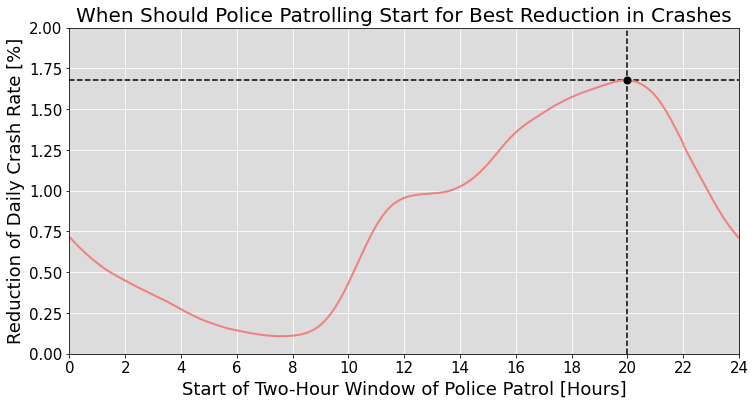

In [21]:
# Create figure
fig, ax = plt.subplots(figsize=(12,6))

# Plot reduction rates
ax.plot(times_patrol, reduction_rates*100, linewidth=2, color='lightcoral')

# Mark best window
best_idx = np.argmax(reduction_rates)
ax.scatter(times_patrol[best_idx], reduction_rates[best_idx]*100, color='k', s=50, zorder=4)
ax.vlines(times_patrol[best_idx],0,2, linestyle='dashed', color='k')
ax.hlines(reduction_rates[best_idx]*100,0,24, linestyle='dashed', color='k')

# Look cool
ax.set_facecolor('gainsboro')
ax.grid(color='white')
ax.set_xlabel('Start of Two-Hour Window of Police Patrol [Hours]', fontsize=18)
ax.set_ylabel('Reduction of Daily Crash Rate [%]', fontsize=18)
ax.set_title('When Should Police Patrolling Start for Best Reduction in Crashes', fontsize=20)
plt.xticks(bins[::2],fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,24)
plt.ylim(0,2)

if SavePlots: plt.savefig('Plots/2b_patrols.png')
plt.show()

In [22]:
print('max reduction is:', np.max(reduction_rates))
print(f'obtained with patrolling beginning at {times_patrol[np.argmax(reduction_rates)]} hours')

max reduction is: 0.016780353954380083
obtained with patrolling beginning at 19.966666666666665 hours


In [23]:
print(f'19:{0.966666666666665*60:.0f}')

19:58


# PROBLEM 2C
Create a 2-dimensional KDE PDF from the crash data using
the latitude and longitude with an Epanechnikov kernel
and a bandwidth of 0.01 in both dimensions

- There is a problem with MANY nan values in the array. Did I read it in wrong or used the wrong columns or what is up? For now I just remove all nans but this should be looked into. lon2 and lat2 has less nan values see the descriptions to see why. Can i combine them somehow?
- is the pdf normalised?

In [24]:
# Define bandwidth
h = 0.01

# Put data together into one array, should have shape (n_samples, n_features)
nan_mask = ( ~np.isnan(data['lat']) )
xy = np.stack([data['lon'][nan_mask], data['lat'][nan_mask]], axis=1)

# Define KDE model
kde_2D = KernelDensity(kernel='epanechnikov', bandwidth=h).fit(xy)

# Define the grid we want to evaluate the pdf at
n_plot = 1000
x_arr = np.linspace(-78.25, -79.25, n_plot)
y_arr = np.linspace(35.5, 36.083, n_plot)
# Make it into meshgrid
XX, YY = np.meshgrid(x_arr, y_arr)
# Convert it into the format sklearn wants
xy_plot = np.stack([XX.ravel(), YY.ravel()], axis=1)

# Get the pdf (score samples is log likelihood, exp returns it to probability)
pdf_2D = np.exp( kde_2D.score_samples(xy_plot) )
# Reshape it to meshgrid dimensions
pdf_2D = pdf_2D.reshape(n_plot, n_plot)

In [26]:
# Get percentage of crashes within the following box
lon_box = [-78.76, -78.72]
lat_box = [35.74, 35.78]

# Get step size in each direction
dx = x_arr[0] - x_arr[1]
dy = y_arr[1] - y_arr[0]

# Define mask that gives us the box
lon_mask = (x_arr > lon_box[0]) & (x_arr < lon_box[1])
lat_mask = (y_arr > lat_box[0]) & (y_arr < lat_box[1])
LON_mask, LAT_mask = np.meshgrid(lon_mask, lat_mask)
box_mask = LON_mask & LAT_mask

# Sum within that box and times with binwidth
box_integral = np.sum( pdf_2D[box_mask] * dx * dy )

# we integrate it all to to make sure it is normalised
total_integral = np.sum(pdf_2D * dx * dy)

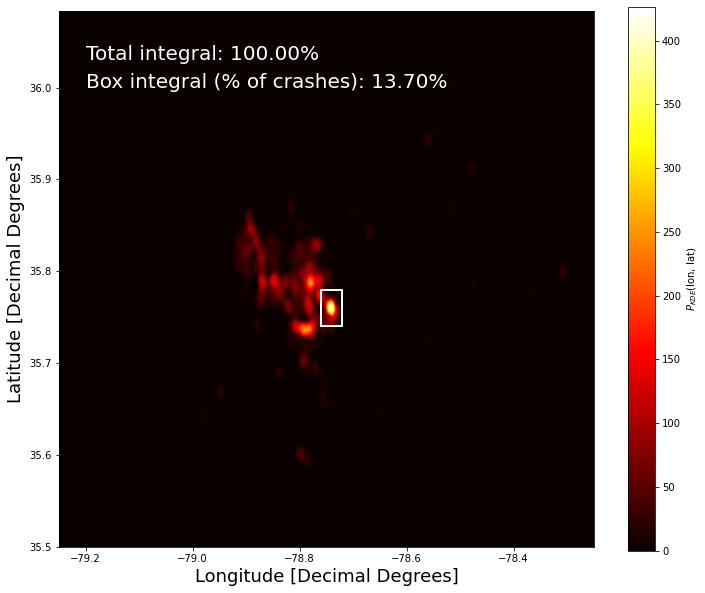

In [27]:
fig, ax = plt.subplots(figsize=(12,10))

# Plotting
sc = ax.pcolormesh(x_arr, y_arr, pdf_2D, shading='auto', cmap='hot')
ax.set_box_aspect(1)

# Label things
ax.set_xlabel('Longitude [Decimal Degrees]', fontsize=18)
ax.set_ylabel('Latitude [Decimal Degrees]', fontsize=18)
cbar = fig.colorbar(sc, label=r'$P_{KDE}$(lon, lat)')

# mark square we are interested in
box = Rectangle((lon_box[0], lat_box[0]), lon_box[1]-lon_box[0] , lat_box[1]-lat_box[0] , \
                linewidth=2, edgecolor='white', facecolor='none')
ax.add_patch(box)

# Denote integrals
ax.text(x=-79.2, y=36.03, s=f'Total integral: {total_integral*100:.2f}%', color='white', fontsize=20, zorder=5)
ax.text(x=-79.2, y=36, s=f'Box integral (% of crashes): {box_integral*100:.2f}%', color='white', fontsize=20, zorder=5)

if SavePlots: plt.savefig('Plots/2D_pdf.png')

plt.show()

so the percentage of crashes inside the box is 13.7%